In [19]:
import torch
import torch.nn as nn
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from IPython.display import display, clear_output
import random
from tqdm import tqdm
import pickle 

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY, COMPLEX_MOVEMENT, SIMPLE_MOVEMENT
import gym
from gym import spaces
import torchvision

from torchvision import models
from torchvision.models.resnet import ResNet18_Weights

In [20]:
class max_skip_environment(gym.Wrapper):

    def __init__(self, env, skip=4):
        super(max_skip_environment, self).__init__(env)
        self._skip = skip  
    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

class frames_64(gym.Wrapper):

    def __init__(self, env):
        super(frames_64, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(64, 64, 1), dtype=np.uint8)

    def process_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (64, 64), interpolation=cv2.INTER_AREA)
        frame = frame[:, :, None]
        return frame

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.process_frame(obs), reward, done, info

    def reset(self):
        return self.process_frame(self.env.reset())


class pytorch_img(gym.ObservationWrapper):
    def __init__(self, env):
        super(pytorch_img, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = spaces.Box(low=0.0, high=1.0,
                                            shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                            dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class scale_frame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class buffer_wrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps=4):

        super(buffer_wrapper, self).__init__(env)
        self.observation_space = spaces.Box(env.observation_space.low.repeat(n_steps, axis=0),
                                            env.observation_space.high.repeat(n_steps, axis=0),
                                            dtype=np.float32)
        self.buffer = np.zeros_like(self.observation_space.low, dtype=np.float32)

    def observation(self, observation):

        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = max_skip_environment(env)
    env = frames_64(env)
    env = pytorch_img(env)
    env = buffer_wrapper(env, 4)
    env = scale_frame(env)
    return JoypadSpace(env, RIGHT_ONLY)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
class DQNSolver(nn.Module):
    def __init__(self, input_shape, n_actions, num_heads=4, window_size=4, shift_size=2):
        """
        Deep Q-Network (DQN) solver class.

        Args:
        - input_shape (tuple): Shape of the input image (channels, height, width).
        - n_actions (int): Number of possible actions.
        - num_heads (int): Number of attention heads in the Swin Transformer block.
        - window_size (int): Size of the window for the Swin Transformer block.
        - shift_size (int): Size of the shift for the Swin Transformer block.
        """
        super(DQNSolver, self).__init__()
        self.resnet = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.encoder1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu)
        self.encoder2 = self.resnet.layer1
        self.encoder3 = self.resnet.layer2
        self.encoder4 = self.resnet.layer3

        feature_size = 256

        self.swin_transformer = SwinTransformerBlock(dim=feature_size, num_heads=num_heads,
                                                     window_size=window_size, shift_size=shift_size)

        self.fc = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        """
        Forward pass of the DQN solver.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, n_actions).
        """
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        features = self.swin_transformer(enc4)

        features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        features = torch.flatten(features, 1)
        return self.fc(features)


class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=4, shift_size=2):
        """
        Swin Transformer block class.

        Args:
        - dim (int): Dimension of the input tensor.
        - num_heads (int): Number of attention heads.
        - window_size (int): Size of the window for the attention operation.
        - shift_size (int): Size of the shift for the attention operation.
        """
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_heads = num_heads

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size=self.window_size, num_heads=num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        """
        Forward pass of the Swin Transformer block.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, channels, height, width).
        """
        B, C, H, W = x.shape

        x = x.permute(0, 2, 3, 1)
        x = x.reshape(B, H * W, C)
        x = self.norm1(x)

        if self.shift_size > 0:
            x = x.view(B, H, W, C)
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        x = x.view(B, H // self.window_size, self.window_size, W // self.window_size, self.window_size, C)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, self.window_size * self.window_size, C)

        x = self.attn(x)

        x = x.view(-1, self.window_size, self.window_size, C)
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(B, C, H, W)

        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(2, 3))

        x = x.permute(0, 2, 3, 1).reshape(B, H * W, C)
        x = x + self.mlp(self.norm2(x))
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)

        return x


class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        """
        Window Attention module class.

        Args:
        - dim (int): Dimension of the input tensor.
        - window_size (int): Size of the window for the attention operation.
        - num_heads (int): Number of attention heads.
        """
        super().__init__()
        self.scale = dim ** -0.5
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        num_relative_positions = 2 * window_size - 1

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(num_relative_positions * num_relative_positions, num_heads)
        )

        coords_h = torch.arange(window_size)
        coords_w = torch.arange(window_size)
        coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size - 1
        relative_coords[:, :, 1] += window_size - 1
        relative_coords[:, :, 0] *= 2 * window_size - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self, x):
        """
        Forward pass of the Window Attention module.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, dim).

        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, sequence_length, dim).
        """
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias

        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x


Observation shape after steps: (4, 64, 64)


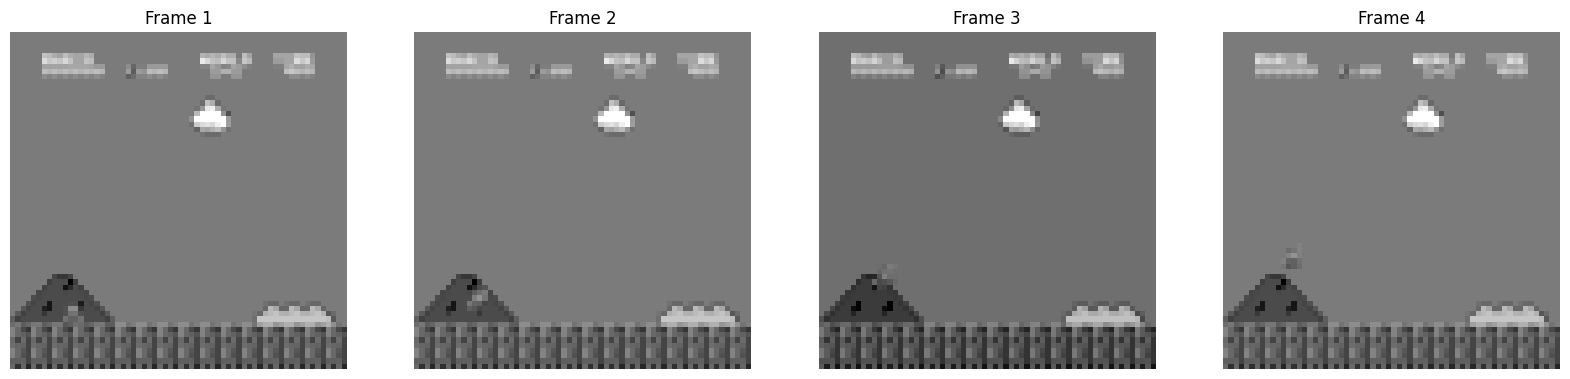

In [23]:
def process_frames():
    """
    This function demonstrates how to process frames in a gym environment.

    It sets up the environment, takes a few steps to populate the buffer with meaningful frames,
    and then plots each channel of the observation.

    Returns:
        None
    """

    # Assuming the environment setup includes the necessary wrappers for processing the frame and adding buffer
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = make_env(env)  # Ensure this applies all necessary wrappers

    # Reset the environment to get the initial observation
    observation = env.reset()

    # Take a few steps to populate the buffer with meaningful frames
    for _ in range(3):
        action = env.action_space.sample()  # Randomly sample an action
        observation, _, _, _ = env.step(action)

    # Now, observation should have 4 meaningful frames
    print("Observation shape after steps:", observation.shape)  # Expected shape (4, 84, 84)

    # Plot each channel
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(observation.shape[0]):
        axes[i].imshow(observation[i], cmap='gray')
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis('off')  # Hide axes

    plt.show()

process_frames()


In [24]:
class DDQN_agent:
    """
    Double Deep Q-Network (DDQN) agent for reinforcement learning.

    Args:
    - state_space: The shape of the state space.
    - act_space: The number of possible actions.
    - max_mem_size: The maximum size of the memory buffer.
    - batch_size: The size of the memory sample used for training.
    - gamma: The discount factor for future rewards.
    - learning_rate: The learning rate for the optimizer.
    - dropout: The dropout rate for the DQN layers.
    - exp_max: The maximum exploration rate.
    - exp_min: The minimum exploration rate.
    - exp_decay: The decay rate for the exploration rate.
    - double_dq: A boolean indicating whether to use double DQN.
    - pretrained: A boolean indicating whether to load pretrained weights.

    Comments:
    - Define DQN Layers: Initializes the DQN network with the given state space and action space.
    - self.predicted_Qnet: The predicted Q-network used for action selection.
    - self.target_Qnet: The target Q-network used for calculating target Q-values.
    - self.optimizer: The optimizer used for updating the predicted Q-network.
    - self.copy: The number of steps before copying the local model weights into the target network.
    - self.step: The current step count.
    - Create memory: Initializes the memory buffers for storing state, action, reward, next state, and done flags.
    - self.memory_sample_size: The size of the memory sample used for training.
    - Learning parameters: Initializes the discount factor, loss function, and exploration rate.
    """

    def __init__(self, state_space, act_space, max_mem_size, batch_size, gamma, learning_rate,
                 dropout, exp_max, exp_min, exp_decay, double_dq, pretrained):
        self.state_space = state_space
        self.act_space = act_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.predicted_Qnet = DQNSolver(state_space, act_space).to(self.device)
        self.target_Qnet = DQNSolver(state_space, act_space).to(self.device)
        
        if self.pretrained:
            self.predicted_Qnet.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
            self.target_Qnet.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                
        self.optimizer = torch.optim.Adam(self.predicted_Qnet.parameters(), lr=learning_rate)
        self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
        self.step = 0
        

        # Create memory
        self.max_mem_size = max_mem_size
        if self.pretrained:
            self.state_memory = torch.load("STATE_MEM.pt")
            self.action_memory = torch.load("ACTION_MEM.pt")
            self.reward_memory = torch.load("REWARD_MEM.pt")
            self.second_state_memory = torch.load("STATE2_MEM.pt")
            self.final_memory = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.state_memory = torch.zeros(max_mem_size, *self.state_space)
            self.action_memory = torch.zeros(max_mem_size, 1)
            self.reward_memory = torch.zeros(max_mem_size, 1)
            self.second_state_memory = torch.zeros(max_mem_size, *self.state_space)
            self.final_memory = torch.zeros(max_mem_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exp_max = exp_max
        self.exploration_rate = exp_max
        self.exp_min = exp_min
        self.exp_decay = exp_decay

    def remember(self, state, action, reward, state2, done):
        """
        Stores an experience in the memory buffer.

        Args:
        - state: The current state.
        - action: The action taken.
        - reward: The reward received.
        - state2: The next state.
        - done: A flag indicating whether the episode is done.
        """
        self.state_memory[self.ending_position] = state.float()
        self.action_memory[self.ending_position] = action.float()
        self.reward_memory[self.ending_position] = reward.float()
        self.second_state_memory[self.ending_position] = state2.float()
        self.final_memory[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_mem_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_mem_size)
        
    def recall(self):
        """
        Retrieves a random sample of experiences from the memory buffer.

        Returns:
        - STATE: The sampled states.
        - ACTION: The sampled actions.
        - REWARD: The sampled rewards.
        - STATE2: The sampled next states.
        - DONE: The sampled done flags.
        """
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.state_memory[idx]
        ACTION = self.action_memory[idx]
        REWARD = self.reward_memory[idx]
        STATE2 = self.second_state_memory[idx]
        DONE = self.final_memory[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        """
        Selects an action based on the current state.

        Args:
        - state: The current state.

        Returns:
        - The selected action.
        """
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.act_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.predicted_Qnet(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        """
        Copies the weights of the local model into the target model.
        """
        self.target_Qnet.load_state_dict(self.predicted_Qnet.state_dict())
    
    def experience_replay(self):
        """
        Performs the experience replay step of the DDQN algorithm.
        """
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_Qnet(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.predicted_Qnet(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exp_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exp_min)

In [25]:
def vectorize_action(action, act_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, act_space)]
def render(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    clear_output(wait=True)
    display(plt.gcf())


In [26]:
def run(training_mode, pretrained):
    """
    Run the reinforcement learning algorithm.

    Args:
        training_mode (bool): Flag indicating whether to run in training mode or not.
        pretrained (bool): Flag indicating whether to use pretrained model or not.
    """
    # Create the environment
    env = gym_super_mario_bros.make('SuperMarioBros-v0')
    env = make_env(env)

    # Get the observation space and action space
    observation_space = env.observation_space.shape
    act_space = env.action_space.n

    # Print the action space and observation space
    print(act_space)
    print(observation_space)

    # Create the DDQN agent
    agent = DDQN_agent(state_space=observation_space,
                       act_space=act_space,
                       max_mem_size=30000,
                       batch_size=16,
                       gamma=0.90,
                       learning_rate=0.00025,
                       dropout=0.1,
                       exp_max=1.0,
                       exp_min=0.02,
                       exp_decay=0.99,
                       double_dq=True,
                       pretrained=pretrained)

    num_episodes = 1000
    env.reset()
    total_rewards = []
    last_x_pos = 0
    stagnation_penalty_count = 0  # Track lack of progress
    count = 0

    # Run the episodes
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0

        while True:
            if not training_mode:
                render(env, ep_num)

            # Choose an action
            action = agent.act(state)
            steps += 1

            # Take the action and observe the next state, reward, and terminal flag
            state_next, reward, terminal, info = env.step(int(action[0]))

            # Update the total reward
            total_reward += reward

            # Convert the next state to a tensor
            state_next = torch.Tensor([state_next])

            # Convert the reward and terminal flag to tensors
            reward = torch.tensor([reward]).unsqueeze(0)
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)

            if training_mode:
                # Remember the current state, action, reward, next state, and terminal flag
                agent.remember(state, action, reward, state_next, terminal)

                # Perform experience replay
                agent.experience_replay()

            state = state_next

            if terminal:
                break

        total_rewards.append(total_reward)
        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        count += 1

        if count > 50:
            # Plot the average rewards per 5 episodes
            plt.title("Episodes trained vs. Average Rewards (per 5 eps)")
            plt.plot([0 for _ in range(50)] + np.convolve(total_rewards, np.ones((50,))/50, mode="valid").tolist())
            plt.show()
            count = 1

            if training_mode:
                # Save state and model
                with open("ending_position.pkl", "wb") as f:
                    pickle.dump(agent.ending_position, f)
                with open("num_in_queue.pkl", "wb") as f:
                    pickle.dump(agent.num_in_queue, f)
                with open("total_rewards1.pkl", "wb") as f:
                    pickle.dump(total_rewards, f)
                torch.save(agent.predicted_Qnet.state_dict(), "dq1.pt")
                torch.save(agent.target_Qnet.state_dict(), "dq2.pt")
                torch.save(agent.action_memory, "ACTION_MEM.pt")
                torch.save(agent.state_memory, "STATE_MEM.pt")
                torch.save(agent.reward_memory, "REWARD_MEM.pt")
                torch.save(agent.second_state_memory, "STATE2_MEM.pt")
                torch.save(agent.final_memory, "DONE_MEM.pt")

    env.close()

    if num_episodes > 500:
        # Plot the average rewards per 500 episodes
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()



To use the model that we trained until now and play the game, run the below command (Watch how the game progresses for couple of episodes to see it's performance)

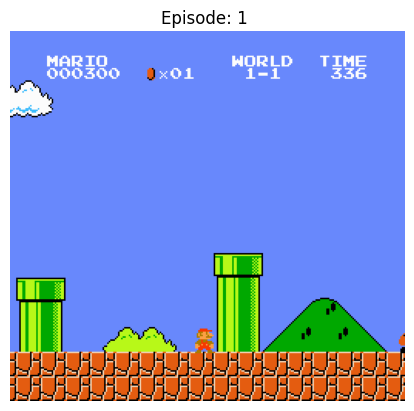

  0%|                                                                             | 1/1000 [01:41<28:04:40, 101.18s/it]


KeyboardInterrupt: 

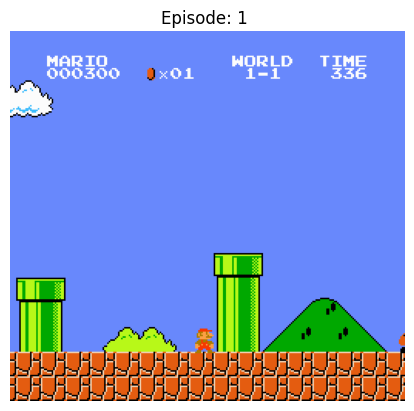

In [27]:
run(training_mode=False, pretrained=True)

To build on top of our model and train it further (train the model not from scratch), run the below command. The weights are saved every 50 episodes.

5
(4, 64, 64)


  0%|                                                                               | 1/1000 [00:29<8:11:46, 29.54s/it]

Total reward after episode 1 is 2306.0


  0%|▏                                                                              | 2/1000 [00:42<5:34:01, 20.08s/it]

Total reward after episode 2 is 2024.0


  0%|▏                                                                              | 3/1000 [00:57<4:48:23, 17.36s/it]

Total reward after episode 3 is 1099.0


  0%|▎                                                                              | 4/1000 [01:04<3:40:20, 13.27s/it]

Total reward after episode 4 is 1131.0


  0%|▍                                                                              | 5/1000 [01:25<4:26:01, 16.04s/it]

Total reward after episode 5 is 1903.0


  1%|▍                                                                              | 6/1000 [01:40<4:20:20, 15.71s/it]

Total reward after episode 6 is 2445.0


  1%|▌                                                                              | 7/1000 [01:55<4:20:23, 15.73s/it]

Total reward after episode 7 is 2357.0


  1%|▋                                                                              | 8/1000 [02:02<3:32:42, 12.87s/it]

Total reward after episode 8 is 1085.0


  1%|▋                                                                              | 9/1000 [02:38<5:31:23, 20.06s/it]

Total reward after episode 9 is 2261.0


  1%|▊                                                                             | 10/1000 [03:07<6:14:01, 22.67s/it]

Total reward after episode 10 is 2269.0


  1%|▊                                                                             | 11/1000 [03:31<6:22:33, 23.21s/it]

Total reward after episode 11 is 1169.0


  1%|▉                                                                             | 12/1000 [03:42<5:19:37, 19.41s/it]

Total reward after episode 12 is 1818.0


  1%|█                                                                             | 13/1000 [04:03<5:30:57, 20.12s/it]

Total reward after episode 13 is 2258.0


  1%|█                                                                             | 14/1000 [04:22<5:25:18, 19.80s/it]

Total reward after episode 14 is 2272.0


  2%|█▏                                                                            | 15/1000 [04:31<4:30:44, 16.49s/it]

Total reward after episode 15 is 1560.0


  2%|█▏                                                                            | 16/1000 [04:58<5:18:52, 19.44s/it]

Total reward after episode 16 is 2195.0


  2%|█▎                                                                            | 17/1000 [05:18<5:22:02, 19.66s/it]

Total reward after episode 17 is 2716.0


  2%|█▍                                                                            | 18/1000 [05:48<6:12:34, 22.76s/it]

Total reward after episode 18 is 3215.0


  2%|█▍                                                                            | 19/1000 [06:10<6:10:55, 22.69s/it]

Total reward after episode 19 is 2694.0


  2%|█▌                                                                            | 20/1000 [06:51<7:39:46, 28.15s/it]

Total reward after episode 20 is 3030.0


  2%|█▋                                                                            | 21/1000 [07:10<6:53:59, 25.37s/it]

Total reward after episode 21 is 2828.0


  2%|█▋                                                                            | 22/1000 [07:47<7:51:51, 28.95s/it]

Total reward after episode 22 is 2599.0


  2%|█▊                                                                            | 23/1000 [08:05<6:57:20, 25.63s/it]

Total reward after episode 23 is 3150.0


  2%|█▊                                                                            | 24/1000 [08:26<6:32:41, 24.14s/it]

Total reward after episode 24 is 2084.0


  2%|█▉                                                                            | 25/1000 [08:35<5:21:11, 19.77s/it]

Total reward after episode 25 is 1553.0


  3%|██                                                                            | 26/1000 [08:49<4:49:32, 17.84s/it]

Total reward after episode 26 is 2324.0


  3%|██                                                                            | 27/1000 [09:12<5:15:28, 19.45s/it]

Total reward after episode 27 is 1648.0


  3%|██▏                                                                           | 28/1000 [09:44<6:17:07, 23.28s/it]

Total reward after episode 28 is 1936.0


  3%|██▎                                                                           | 29/1000 [09:49<4:45:41, 17.65s/it]

Total reward after episode 29 is 725.0


  3%|██▎                                                                           | 30/1000 [10:01<4:17:26, 15.92s/it]

Total reward after episode 30 is 2152.0


  3%|██▍                                                                           | 31/1000 [10:13<3:58:49, 14.79s/it]

Total reward after episode 31 is 1886.0


  3%|██▍                                                                           | 32/1000 [10:27<3:53:21, 14.46s/it]

Total reward after episode 32 is 2234.0


  3%|██▌                                                                           | 33/1000 [10:48<4:27:58, 16.63s/it]

Total reward after episode 33 is 3056.0


  3%|██▋                                                                           | 34/1000 [11:19<5:36:02, 20.87s/it]

Total reward after episode 34 is 2709.0


  4%|██▋                                                                           | 35/1000 [11:40<5:34:47, 20.82s/it]

Total reward after episode 35 is 2259.0


  4%|██▊                                                                           | 36/1000 [12:19<7:04:57, 26.45s/it]

Total reward after episode 36 is 2427.0


  4%|██▉                                                                           | 37/1000 [12:43<6:51:46, 25.66s/it]

Total reward after episode 37 is 1616.0


  4%|██▉                                                                           | 38/1000 [13:01<6:13:10, 23.28s/it]

Total reward after episode 38 is 2222.0


  4%|███                                                                           | 39/1000 [13:18<5:45:55, 21.60s/it]

Total reward after episode 39 is 2470.0


  4%|███                                                                           | 40/1000 [13:45<6:08:18, 23.02s/it]

Total reward after episode 40 is 2338.0


  4%|███▏                                                                          | 41/1000 [14:27<7:38:45, 28.70s/it]

Total reward after episode 41 is 3848.0


  4%|███▎                                                                          | 42/1000 [14:47<6:56:39, 26.10s/it]

Total reward after episode 42 is 2187.0


  4%|███▎                                                                          | 43/1000 [15:37<8:52:45, 33.40s/it]

Total reward after episode 43 is 2944.0


  4%|███▍                                                                          | 44/1000 [16:11<8:55:49, 33.63s/it]

Total reward after episode 44 is 2070.0


  4%|███▌                                                                          | 45/1000 [16:21<7:01:39, 26.49s/it]

Total reward after episode 45 is 1809.0


  5%|███▌                                                                          | 46/1000 [16:34<5:54:06, 22.27s/it]

Total reward after episode 46 is 1060.0


  5%|███▋                                                                          | 47/1000 [16:52<5:33:52, 21.02s/it]

Total reward after episode 47 is 2410.0


  5%|███▋                                                                          | 48/1000 [18:01<9:24:08, 35.55s/it]

Total reward after episode 48 is 3997.0


  5%|███▊                                                                          | 49/1000 [18:08<7:06:23, 26.90s/it]

Total reward after episode 49 is 1087.0


  5%|███▉                                                                          | 50/1000 [18:21<6:01:36, 22.84s/it]

Total reward after episode 50 is 2373.0
Total reward after episode 51 is 2594.0


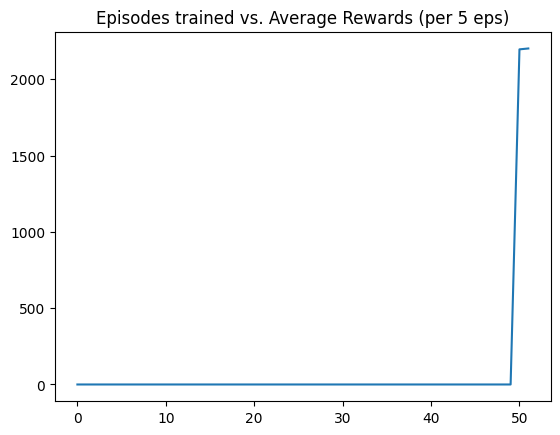

  5%|████                                                                          | 52/1000 [19:06<5:47:49, 22.01s/it]

Total reward after episode 52 is 1502.0


  5%|████▏                                                                         | 53/1000 [19:26<5:38:39, 21.46s/it]

Total reward after episode 53 is 2667.0


  5%|████▏                                                                         | 54/1000 [19:43<5:15:44, 20.03s/it]

Total reward after episode 54 is 2904.0


  6%|████▎                                                                         | 55/1000 [19:55<4:37:33, 17.62s/it]

Total reward after episode 55 is 1657.0


  6%|████▎                                                                         | 56/1000 [20:08<4:13:49, 16.13s/it]

Total reward after episode 56 is 2216.0


  6%|████▍                                                                         | 57/1000 [20:43<5:45:20, 21.97s/it]

Total reward after episode 57 is 2432.0


  6%|████▌                                                                         | 58/1000 [21:12<6:17:05, 24.02s/it]

Total reward after episode 58 is 2481.0


  6%|████▌                                                                         | 59/1000 [21:27<5:32:48, 21.22s/it]

Total reward after episode 59 is 2263.0


  6%|████▋                                                                         | 60/1000 [21:45<5:17:44, 20.28s/it]

Total reward after episode 60 is 1869.0


  6%|████▊                                                                         | 61/1000 [22:09<5:37:49, 21.59s/it]

Total reward after episode 61 is 2841.0


  6%|████▊                                                                         | 62/1000 [22:24<5:07:04, 19.64s/it]

Total reward after episode 62 is 2276.0


  6%|████▉                                                                         | 63/1000 [22:39<4:43:49, 18.17s/it]

Total reward after episode 63 is 2674.0


  6%|████▉                                                                         | 64/1000 [23:05<5:17:43, 20.37s/it]

Total reward after episode 64 is 3049.0


  6%|█████                                                                         | 65/1000 [23:23<5:08:15, 19.78s/it]

Total reward after episode 65 is 2447.0


  7%|█████▏                                                                        | 66/1000 [23:49<5:36:48, 21.64s/it]

Total reward after episode 66 is 1988.0


  7%|█████▏                                                                        | 67/1000 [24:17<6:04:34, 23.45s/it]

Total reward after episode 67 is 3224.0


  7%|█████▎                                                                        | 68/1000 [24:35<5:39:58, 21.89s/it]

Total reward after episode 68 is 2630.0


  7%|█████▍                                                                        | 69/1000 [24:56<5:34:34, 21.56s/it]

Total reward after episode 69 is 2309.0


  7%|█████▍                                                                        | 70/1000 [25:19<5:42:00, 22.06s/it]

Total reward after episode 70 is 3033.0


  7%|█████▌                                                                        | 71/1000 [25:34<5:08:25, 19.92s/it]

Total reward after episode 71 is 2343.0


  7%|█████▌                                                                        | 72/1000 [26:17<6:56:39, 26.94s/it]

Total reward after episode 72 is 3295.0


  7%|█████▋                                                                        | 73/1000 [26:32<5:59:25, 23.26s/it]

Total reward after episode 73 is 1477.0


  7%|█████▊                                                                        | 74/1000 [26:56<6:03:14, 23.54s/it]

Total reward after episode 74 is 2224.0


  8%|█████▊                                                                        | 75/1000 [27:07<5:06:16, 19.87s/it]

Total reward after episode 75 is 2365.0


  8%|█████▉                                                                        | 76/1000 [27:28<5:08:48, 20.05s/it]

Total reward after episode 76 is 2809.0


  8%|██████                                                                        | 77/1000 [27:52<5:25:05, 21.13s/it]

Total reward after episode 77 is 2900.0


  8%|██████                                                                        | 78/1000 [28:12<5:19:34, 20.80s/it]

Total reward after episode 78 is 1849.0


  8%|██████▏                                                                       | 79/1000 [28:29<5:04:47, 19.86s/it]

Total reward after episode 79 is 2250.0


  8%|██████▏                                                                       | 80/1000 [28:47<4:56:38, 19.35s/it]

Total reward after episode 80 is 2219.0


  8%|██████▎                                                                       | 81/1000 [29:11<5:17:19, 20.72s/it]

Total reward after episode 81 is 1952.0


  8%|██████▍                                                                       | 82/1000 [30:06<7:51:53, 30.84s/it]

Total reward after episode 82 is 3374.0


  8%|██████▍                                                                       | 83/1000 [30:18<6:26:20, 25.28s/it]

Total reward after episode 83 is 1852.0


  8%|██████▌                                                                       | 84/1000 [30:44<6:26:50, 25.34s/it]

Total reward after episode 84 is 2333.0


  8%|██████▋                                                                       | 85/1000 [31:02<5:57:14, 23.43s/it]

Total reward after episode 85 is 2447.0


  9%|██████▋                                                                       | 86/1000 [31:31<6:21:23, 25.04s/it]

Total reward after episode 86 is 2470.0


  9%|██████▊                                                                       | 87/1000 [31:51<5:57:21, 23.49s/it]

Total reward after episode 87 is 2812.0


  9%|██████▊                                                                       | 88/1000 [32:04<5:08:17, 20.28s/it]

Total reward after episode 88 is 1654.0


  9%|██████▉                                                                       | 89/1000 [32:49<7:02:26, 27.82s/it]

Total reward after episode 89 is 3244.0


  9%|███████                                                                       | 90/1000 [33:10<6:30:57, 25.78s/it]

Total reward after episode 90 is 3607.0


  9%|███████                                                                       | 91/1000 [33:28<5:53:44, 23.35s/it]

Total reward after episode 91 is 2824.0


  9%|███████▏                                                                      | 92/1000 [33:51<5:49:39, 23.11s/it]

Total reward after episode 92 is 2202.0


  9%|███████▎                                                                      | 93/1000 [34:03<5:00:26, 19.87s/it]

Total reward after episode 93 is 1528.0


  9%|███████▎                                                                      | 94/1000 [34:15<4:26:23, 17.64s/it]

Total reward after episode 94 is 2237.0


 10%|███████▍                                                                      | 95/1000 [34:51<5:49:41, 23.18s/it]

Total reward after episode 95 is 3111.0


 10%|███████▍                                                                      | 96/1000 [35:15<5:49:16, 23.18s/it]

Total reward after episode 96 is 2719.0


 10%|███████▌                                                                      | 97/1000 [35:24<4:46:30, 19.04s/it]

Total reward after episode 97 is 1444.0


 10%|███████▋                                                                      | 98/1000 [35:44<4:48:35, 19.20s/it]

Total reward after episode 98 is 2416.0


 10%|███████▋                                                                      | 99/1000 [35:58<4:24:35, 17.62s/it]

Total reward after episode 99 is 2528.0


 10%|███████▋                                                                     | 100/1000 [36:18<4:36:56, 18.46s/it]

Total reward after episode 100 is 2065.0
Total reward after episode 101 is 2423.0


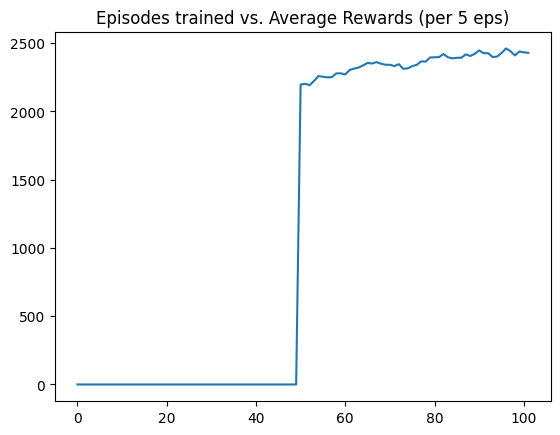

 10%|███████▊                                                                     | 102/1000 [37:16<5:54:07, 23.66s/it]

Total reward after episode 102 is 2822.0


 10%|███████▉                                                                     | 103/1000 [37:38<5:46:16, 23.16s/it]

Total reward after episode 103 is 2768.0


 10%|████████                                                                     | 104/1000 [38:10<6:24:48, 25.77s/it]

Total reward after episode 104 is 2029.0


 10%|████████                                                                     | 105/1000 [38:25<5:37:06, 22.60s/it]

Total reward after episode 105 is 2165.0


 11%|████████▏                                                                    | 106/1000 [38:46<5:28:12, 22.03s/it]

Total reward after episode 106 is 1498.0


 11%|████████▏                                                                    | 107/1000 [39:12<5:48:55, 23.44s/it]

Total reward after episode 107 is 2871.0


 11%|████████▎                                                                    | 108/1000 [39:31<5:25:05, 21.87s/it]

Total reward after episode 108 is 2069.0


In [ ]:
run(training_mode=True, pretrained=True)

To train the model from scratch, run the below command

In [ ]:
run(training_mode=True, pretrained=False)